In [1]:
import os
import sys
import argparse
from typing import Tuple
from tensorboardX import SummaryWriter
import copy
import time
import math
import numpy as np
import pickle

# Progressbar
from tqdm import tqdm

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Highlevel from Pytorch
import torch as T
from torch import nn, Tensor
import torch.optim as opt

# Neural Network parts from Pytorch
from torch.nn import TransformerEncoder, TransformerEncoderLayer, init
import torch.nn.functional as F

# Pytorch's Dataset and Dataloader
from torch.utils.data import dataset
from torch.utils.data import DataLoader

# Dataset used
from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

# Custom Libraries
import utils
import transformer_modell

device = T.device('cuda' if T.cuda.is_available() else 'cpu')

model = transformer_modell.TransformerModel(33280, 200, 2, 200, 2, 0.2).to(device)

lr        = 5.0  # learning rate
optimizer = T.optim.SGD(model.parameters(), lr=lr)
scheduler = T.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.95, patience=max(10, 1))

In [81]:
all_train_loss_prune = np.array([])
all_train_loss_reint = np.array([])
with open(f"{os.getcwd()}/pruning/0/dumps/summary_plot_data/compression.dat", "rb") as input_file:
    comp = pickle.load(input_file)
for _c in comp:
    with open(f"{os.getcwd()}/pruning/0/dumps/train_loss/all_train_loss_{_c}.dat", "rb") as input_file:
        all_train_loss_prune_temp   = pickle.load(input_file)
    all_train_loss_prune = np.concatenate((all_train_loss_prune, all_train_loss_prune_temp))
with open(f"{os.getcwd()}/reintroduction/old_identical/0/dumps/reint_summary_plot_data/compression.dat", "rb") as input_file:
    comp_reint = pickle.load(input_file)
for c in comp_reint:
    with open(f"{os.getcwd()}/reintroduction/old_identical/0/dumps/train_loss_reint/all_train_loss_{c}.dat", "rb") as input_file:
        all_train_loss_reint_temp   = pickle.load(input_file)
    all_train_loss_reint = np.concatenate((all_train_loss_reint, all_train_loss_reint_temp))


all_val_loss_prune = np.array([])
all_val_loss_reint = np.array([])
with open(f"{os.getcwd()}/pruning/0/dumps/summary_plot_data/compression.dat", "rb") as input_file:
    comp = pickle.load(input_file)
for _c in comp:
    with open(f"{os.getcwd()}/pruning/0/dumps/validation_loss/all_val_loss_{_c}.dat", "rb") as input_file:
        all_val_loss_prune_temp   = pickle.load(input_file)
    all_val_loss_prune = np.concatenate((all_val_loss_prune, all_val_loss_prune_temp))
with open(f"{os.getcwd()}/reintroduction/old_identical/0/dumps/reint_summary_plot_data/compression.dat", "rb") as input_file:
    comp_reint = pickle.load(input_file)
for c in comp_reint:
    with open(f"{os.getcwd()}/reintroduction/old_identical/0/dumps/validation_loss_reint/all_val_loss_{c}.dat", "rb") as input_file:
        all_val_loss_reint_temp   = pickle.load(input_file)
    all_val_loss_reint = np.concatenate((all_val_loss_reint, all_val_loss_reint_temp))

all_train_loss = np.concatenate((all_train_loss_prune,all_train_loss_reint))
all_val_loss = np.concatenate((all_val_loss_prune,all_val_loss_reint))

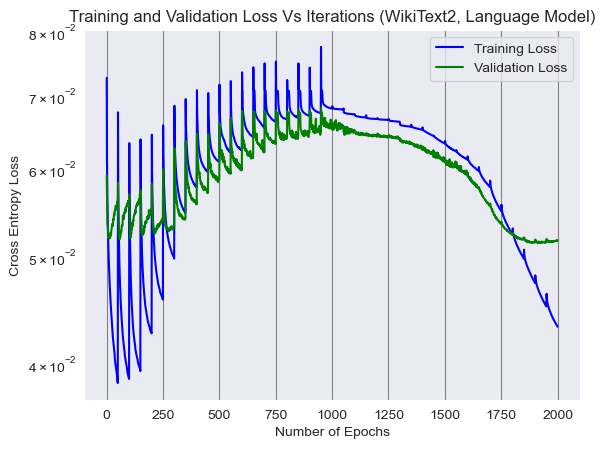

In [86]:
plt.plot(np.arange(1, 2001), all_train_loss, c="b", label="Training Loss")
plt.plot(np.arange(1, 2001), all_val_loss, c="g", label="Validation Loss")
plt.yscale('log')
plt.title(f"Training and Validation Loss Vs Iterations (WikiText2, Language Model)")
plt.xlabel("Number of Epochs")
plt.ylabel("Cross Entropy Loss")
plt.legend()
plt.grid(color="gray")

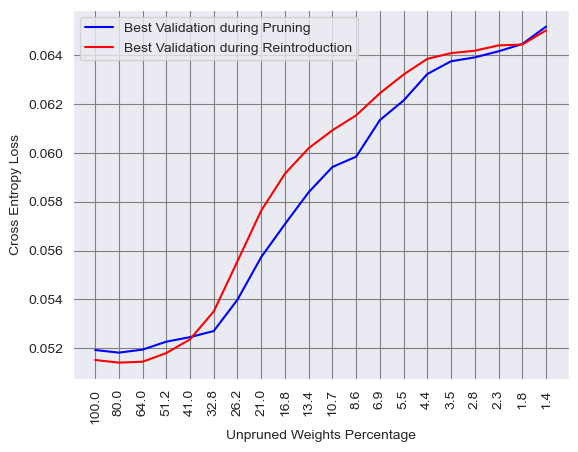

In [77]:
with open(f"{os.getcwd()}/pruning/0/dumps/summary_plot_data/best_val.dat", "rb") as input_file:
    best_val = pickle.load(input_file)
with open(f"{os.getcwd()}/reintroduction/old_identical/0/dumps/reint_summary_plot_data/best_val.dat", "rb") as input_file:
    best_val_reint = pickle.load(input_file)
    best_val_reint = np.flip(best_val_reint)
with open(f"{os.getcwd()}/pruning/0/dumps/summary_plot_data/compression.dat", "rb") as input_file:
    comp = pickle.load(input_file)
a = range(20)
plt.plot(a, best_val, c="b", label="Best Validation during Pruning")
plt.plot(a, best_val_reint, c="r", label="Best Validation during Reintroduction")
plt.xlabel("Unpruned Weights Percentage")
plt.ylabel("Cross Entropy Loss")
plt.xticks(a, comp, rotation="vertical")
plt.legend()
plt.grid(color="gray")

In [78]:
train_loss_all = np.array([])
for i in range(40):
    with open(f"{os.getcwd()}/baseline/1/dumps/train_loss/all_train_loss_{i}.dat", "rb") as input_file:
        temp   = pickle.load(input_file)
    train_loss_all = np.concatenate((train_loss_all,temp))
train_loss_all = train_loss_all

In [79]:
val_loss_all = np.array([])
for i in range(40):
    with open(f"{os.getcwd()}/baseline/1/dumps/validation_loss/all_val_loss_{i}.dat", "rb") as input_file:
        temp   = pickle.load(input_file)
    val_loss_all = np.concatenate((val_loss_all,temp))
val_loss_all = val_loss_all

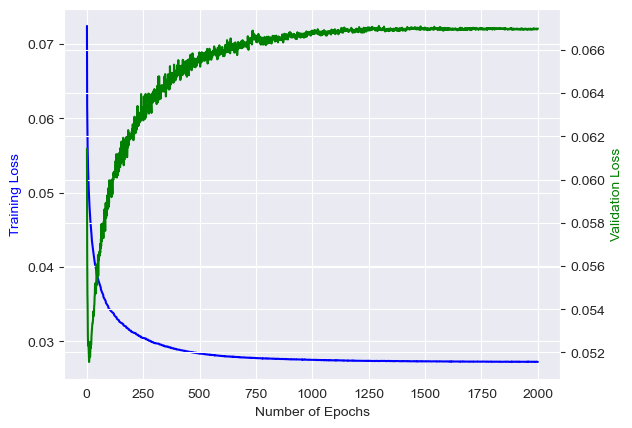

In [80]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(np.arange(1, 2001), train_loss_all, c="b", label="Train Loss")
ax2.plot(np.arange(1, 2001), val_loss_all, c="g", label="Validation Loss")

ax1.set_xlabel("Number of Epochs")
ax1.set_ylabel("Training Loss", c="b")
ax2.set_ylabel("Validation Loss", c="g")

plt.show()

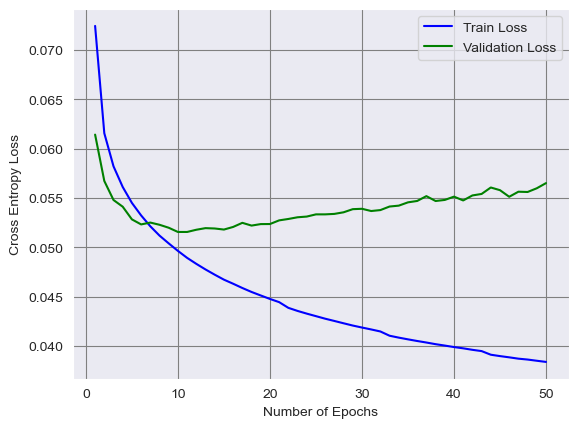

In [6]:
plt.plot(np.arange(1, 51), train_loss_all[:50], c="b", label="Train Loss")
plt.plot(np.arange(1, 51), val_loss_all[:50], c="g", label="Validation Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Cross Entropy Loss")
plt.legend()
plt.grid(color="gray")

In [75]:
with open(f"{os.getcwd()}/baseline/1/dumps/summary_plot_data/best_val.dat","rb") as input_file:
    val_loss_checkpoint = pickle.load(input_file)
val_loss_checkpoint = val_loss_checkpoint
best_checkpoint = val_loss_checkpoint.min()

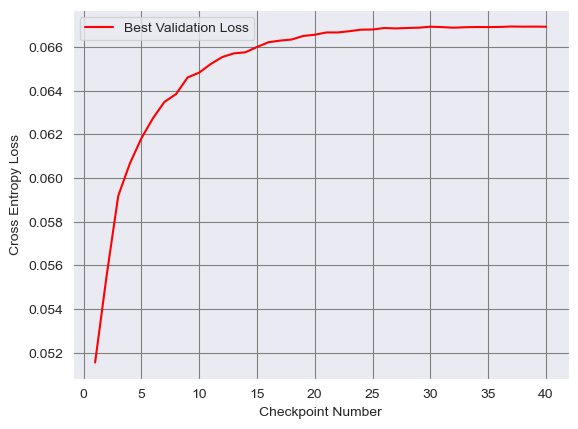

In [76]:
plt.plot(np.arange(1, 41), val_loss_checkpoint, c="r", label="Best Validation Loss")
plt.xlabel("Checkpoint Number")
plt.ylabel("Cross Entropy Loss")
#plt.yscale("log")
plt.legend()
plt.grid(color="gray")

In [72]:
choice    = ["old", "rng", "top"]
variation = ["dynamic", "freezing", "identical"]
val_reint = np.full((9,20), np.inf)
i = 0
for c in choice:
    for v in variation:
        with open(f"{os.getcwd()}/reintroduction/{c+'_'+v}/0/dumps/reint_summary_plot_data/best_val.dat", "rb") as input_file:
            v_r          = pickle.load(input_file)
            val_reint[i] = np.flip(v_r)
            i += 1
print(val_reint)

[[0.05232095 0.05210516 0.05201684 0.05207361 0.05247835 0.05310161
  0.05440095 0.05580473 0.0571748  0.05926609 0.06072633 0.0613094
  0.06203351 0.06265013 0.06331321 0.06380628 0.06417008 0.06444223
  0.06460499 0.06477105]
 [0.05417746 0.05538628 0.05674483 0.0580121  0.05952002 0.06129904
  0.06265724 0.06340664 0.06382022 0.0639487  0.06403443 0.06415601
  0.06432615 0.06448082 0.06485947 0.06484419 0.06498721 0.06502872
  0.06515661 0.06534356]
 [0.05151625 0.0514072  0.05144571 0.05179971 0.0523625  0.053507
  0.05556571 0.0576391  0.05915201 0.06019743 0.06093072 0.06154208
  0.06244761 0.06321615 0.06385889 0.06409212 0.06419132 0.06440938
  0.06444442 0.06502346]
 [0.05076804 0.05108746 0.05148981 0.05214183 0.05316522 0.05441397
  0.05632821 0.05788731 0.05931797 0.06052525 0.06091275 0.06213872
  0.06324553 0.06347251 0.06402544 0.06419822 0.06429626 0.06444043
  0.06481401 0.06518554]
 [0.05643536 0.05749454 0.05884194 0.06020285 0.06151182 0.06250754
  0.06313526 0.0634

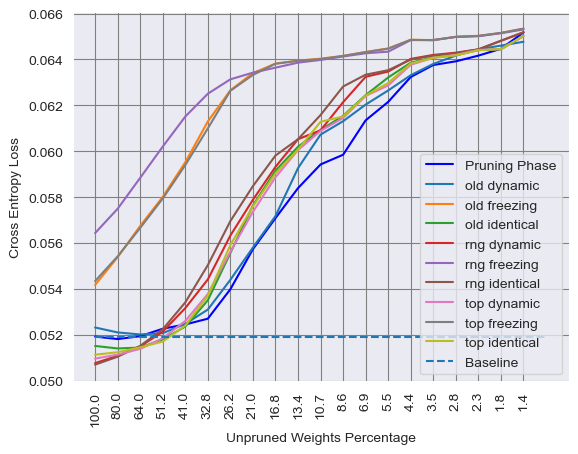

In [73]:
with open(f"{os.getcwd()}/pruning/0/dumps/summary_plot_data/best_val.dat", "rb") as input_file:
    best_val = pickle.load(input_file)
with open(f"{os.getcwd()}/pruning/0/dumps/summary_plot_data/compression.dat", "rb") as input_file:
    comp = pickle.load(input_file)
best_checkpoint = best_val[0]
a = range(20)
i = 0
plt.plot(a, best_val, c="b", label="Pruning Phase")
for c in choice:
    for v in variation:
        plt.plot(a, val_reint[i], label=f"{c} {v}")
        i += 1
plt.hlines(y=best_checkpoint, xmin=0, xmax=20, ls='--', label="Baseline")
plt.xlabel("Unpruned Weights Percentage")
plt.ylabel("Cross Entropy Loss")
plt.xticks(a, comp, rotation="vertical")
plt.legend()
plt.grid(color="gray")

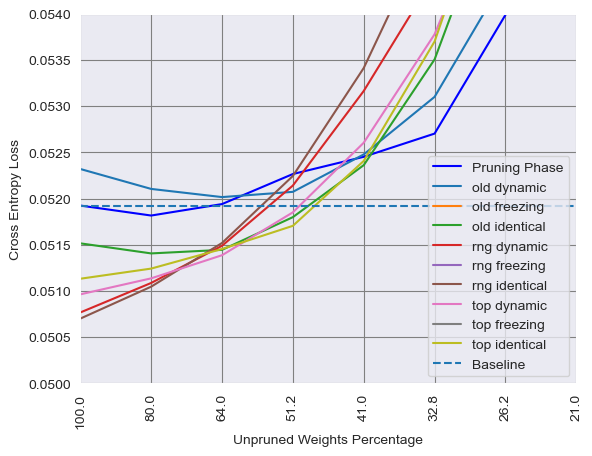

In [74]:
with open(f"{os.getcwd()}/pruning/0/dumps/summary_plot_data/best_val.dat", "rb") as input_file:
    best_val = pickle.load(input_file)
with open(f"{os.getcwd()}/pruning/0/dumps/summary_plot_data/compression.dat", "rb") as input_file:
    comp = pickle.load(input_file)
best_checkpoint = best_val[0]
a = range(20)
i = 0
plt.plot(a, best_val, c="b", label="Pruning Phase")
for c in choice:
    for v in variation:
        plt.plot(a, val_reint[i], label=f"{c} {v}")
        i += 1
plt.hlines(y=best_checkpoint, xmin=0, xmax=20, ls='--', label="Baseline")
plt.ylim(0.050, 0.054)
plt.xlabel("Unpruned Weights Percentage")
plt.ylabel("Cross Entropy Loss")
plt.xticks(a, comp, rotation="vertical")
plt.xlim(0,7)
plt.legend()
plt.grid(color="gray")

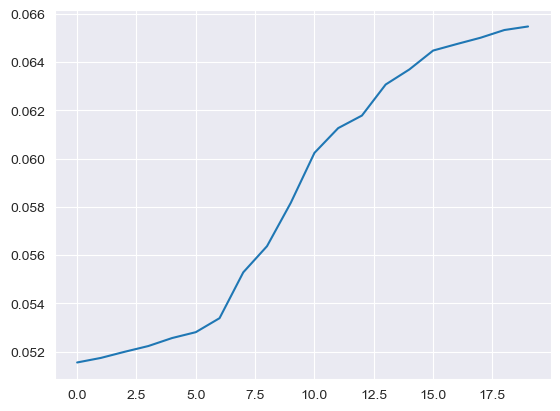

In [87]:
PATH = f"{os.getcwd()}/pruning/1/dumps/summary_plot_data/best_val.dat"
with open(PATH, "rb") as input_file:
    val = pickle.load(input_file)
val.dump(PATH)
plt.plot(range(20),val)

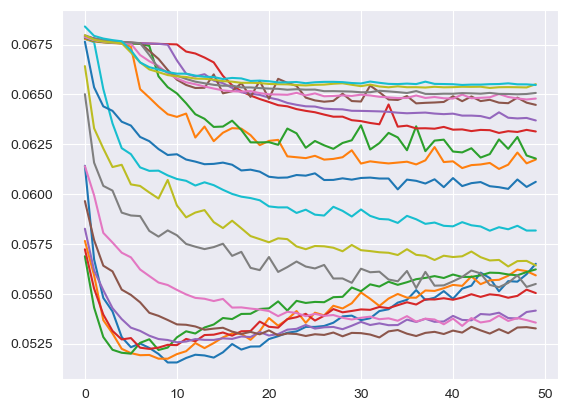

In [88]:
with open(f"{os.getcwd()}/pruning/1/dumps/summary_plot_data/compression.dat", "rb") as input_file:
    comp = pickle.load(input_file)
for c in comp:
    PATH = f"{os.getcwd()}/pruning/1/dumps/validation_loss/all_val_loss_{c}.dat"
    with open(PATH, "rb") as input_file:
        val = pickle.load(input_file)
    val.dump(PATH)
    plt.plot(range(50),val)

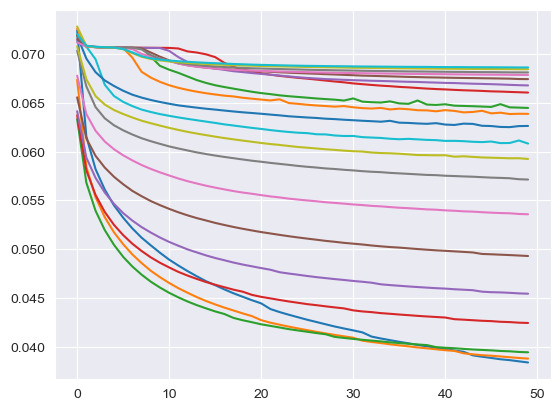

In [90]:
with open(f"{os.getcwd()}/pruning/1/dumps/summary_plot_data/compression.dat", "rb") as input_file:
    comp = pickle.load(input_file)
for c in comp:
    PATH = f"{os.getcwd()}/pruning/1/dumps/train_loss/all_train_loss_{c}.dat"
    with open(PATH, "rb") as input_file:
        train = pickle.load(input_file)
    train.dump(PATH)
    plt.plot(range(50), train)